# 2D Stationary/Transient Stokes/Oseen Flow in an Open/Closed Channel     

<b>Remarks</b>

##  Import Packages

In [1]:
using BlockArrays
using LinearAlgebra
using UnPack
using LinearSolve 
using SparseArrays
using Ferrite
using FerriteGmsh 
using OrdinaryDiffEq
using DifferentialEquations
using Plots 
using WriteVTK

In [2]:
using BlockArrays
BlockedArray(randn(3,5), [2,1], [2,3])

LoadError: UndefVarError: `BlockedArray` not defined

In [3]:
using BlockArrays
BlockArray(randn(3,5), [2,1], [2,3])

2×2-blocked 3×5 BlockMatrix{Float64}:
 -0.645111  -0.0497166  │   0.598496   0.180956  -1.3682  
  0.211423  -0.258548   │  -1.84878   -0.678954  -0.575515
 ───────────────────────┼─────────────────────────────────
  1.56544    1.4367     │  -2.2877     0.907993  -0.88852 

## Section 1: Introduction 

### Problem to Solve

<b>Computational Domain</b> Let $L = 1 \, \text{m}$ and $H = 0.1 \, \text{m}$. We consider a two-dimensional <b>rectangular open channel</b> $(x,y) \in \Omega = (0,L) \times (0,H)$. The mesh on $\Omega$ is generated using Ferrite in built meshing tools.  

<b>Fields</b>
- $\rho$ is the density (units kg/m$^3$)
- $\mathbf{u} = (u_x, u_y)^T$ is the velocity vector  (units m/s)
- $p$ is the pressure field (divided by density) (units N/m$^2$)
- $\hat{p}$ is the kinematic pressure field (divided by density) (units m$^2$/s$^2$)
- $\mathbf{\hat{f}}$ is the body force. In the absence of the porous material, we set $\mathbf{\hat{f}} = \mathbf{0}$. In the presence of the porous material, we set $\mathbf{\hat{f}} = \gamma \, \mathbf{v}$, where $\gamma$ is a suitably choosen damping coefficient.  
- $\mathbf{f}$ is the body force per unit of mass ($\mathbf{\hat{f}} = \mathbf{0}$ and thus $\mathbf{f} = \mathbf{0}$ for our case)

In later computations, dividing by density will no longer feasible. 

<b>Material Parameters</b>
- $\mu$ is the dynamic viscosity (units m$^2$/s)
- $\nu = \mu/\rho$ is the kinematic viscosity (units kg/(m s))

<b>Governing Equations</b> We consider solving stationary and transient Stokes flow. Transient simulations are carried out starting from rest (ramping to obtain suitable initial guess for simulations) until reaching
a steady-state simulatation. 

### Governing Equations

The transient Stokes flow is governed by the following system of equations:

#### Momentum Equation
$$\rho \frac{\partial \mathbf{u}}{\partial t} = \mu \nabla^2 \mathbf{u} - \nabla \hat{p} + \mathbf{\hat{f}} \quad \text{in } \Omega$$

or 

$$\frac{\partial \mathbf{u}}{\partial t} = \left( \mu / \rho \right) \nabla^2 \mathbf{u} - \nabla \left( \hat{p} / \rho \right) + \mathbf{\hat{f}}/\rho \quad \text{in } \Omega$$

or 

$$\frac{\partial \mathbf{u}}{\partial t} = \nu \nabla^2 \mathbf{u} - \nabla p + \mathbf{f} \quad \text{in } \Omega$$

#### Continuity Equation (Incompressibility)
$$\nabla \cdot \mathbf{u} = 0 \quad \text{in } \Omega$$

Observe that the continuity equation contains no time-derivative. After spatial discretization, the continuity equations act as a set of algebraic constraints for the discretized momentum equation. This will result in a set of differential-algebraic equations.   

### Boundary Conditions for Open Channel Case 

#### 1. Inlet Boundary (Parabolic Inflow)
At the left boundary ($x = 0$):
$$\mathbf{u}(0, y, t) = \begin{pmatrix} u_{\text{in}}(y, t) \\ 0 \end{pmatrix}$$

where the parabolic profile is:
$$u_{\text{in}}(y, t) = v_{\text{in}}(t) \cdot \frac{y(H-y)}{H^2/4}$$
 
with $v_{\text{in}}(t)$ being the time-dependent inlet velocity amplitude. Time-dependency is used to gradually increase the inflow until reaching nominal value. 

#### 2. Wall Boundaries (No-slip)
At the top and bottom walls ($y = 0$ and $y = H$):
$$\mathbf{u} = \mathbf{0}$$

#### 3. Outlet Boundary (Fixed Pressure)
At the right boundary ($x = L$):
$$p = 0$$
(for now we consider 0 mean pressure)

### Boundary Conditions for Closed Vessel Case 

#### 1. Inlet Boundary (Parabolic Inflow)
At the left boundary ($x = 0$):
$$\mathbf{u}(0, y, t) = \begin{pmatrix} u_{\text{in}}(y, t) \\ 0 \end{pmatrix}$$

where the parabolic profile is:
$$u_{\text{in}}(y, t) = v_{\text{in}}(t) \cdot \frac{y(H-y)}{H^2/4}$$
 
with $v_{\text{in}}(t)$ being the time-dependent inlet velocity amplitude. Time-dependency is used to gradually increase the inflow until reaching nominal value. 

#### 2. Wall Boundaries (No-slip)
At the top and bottom walls ($y = 0$ and $y = H$):
$$\mathbf{u} = \mathbf{0}$$

### Initial Conditions
At $t = 0$ we impose a condition compatible with the ramping of the inflow for the open channel case or ramping of the total pressure in case of the closed vessel case 
$$\mathbf{u}(\mathbf{x}, 0) = \mathbf{0} \text{ and } p(\mathbf{x}, 0) = 0 \, . $$

### Weak Formulation

The weak formulation involves finding $\mathbf{u} \in \mathbf{V}$ and $p \in Q$ such that:

$$\int_\Omega \mathbf{v} \cdot \frac{\partial \mathbf{u}}{\partial t} \, d\Omega + \int_\Omega \mu \nabla \mathbf{v} : \nabla \mathbf{u} \, d\Omega - \int_\Omega (\nabla \cdot \mathbf{v}) p \, d\Omega = 0$$

$$\int_\Omega q (\nabla \cdot \mathbf{u}) \, d\Omega = 0$$

for all test functions $\mathbf{v} \in \mathbf{V}_0$ and $q \in Q$.

### Linear System Solve  

After finite element discretization, a linear system that couples the velocity and pressure unknowns is obtained. This linear system can be solved by sparse direct or iterative methods. Schur complement methods play an important in preconditioning iterative solution methods. More information on iterative solution methods for discrete Stokes systems is provided in these [lecture notes](https://math.mit.edu/classes/18.086/2006/am65.pdf). 

### Closed-Form Solution in Case of Stationary Stokes for the Open Channel 

Assume stationary Stokes flow on an open rectangular channel. Assume ${\mathbf v} = \left(u(y), 0,0\right)$ with $u(y)$ a parabolic profile to be the imposed inlet velocity. Then ${\mathbf v}$ is a closed-form solution provided a linearly decreasing pressure $p(x,y)$. Indeed, ${\mathbf v}$ trivially satisfies the convervation of mass equation $\nabla \cdot {\mathbf v} = 0$. The condition $\nu \nabla^2 \mathbf{u} = \nabla p$ reduces to 
$$ \nu \, \begin{pmatrix} \nabla^2 u & 0 \\ 0 & \nabla^2 v \end{pmatrix} = 
          \begin{pmatrix} \partial p / \partial x \\ \partial p / \partial y \end{pmatrix} $$

or $\nu \, \partial^2 u / \partial y^2  = \partial p / \partial x $ and $ 0 = \partial p / \partial y$. The first equation yields the following the expression for the pressure drop in the channel 

$$ \frac{\partial p}{\partial x} = - \frac{8 \, v_{\text{in}} \, \nu}{H^2} $$ 

This is the same equation as in [Plane Poiseuille flow](https://en.wikipedia.org/wiki/Hagen–Poiseuille_equation#Plane_Poiseuille_flow). 
The pressure drop is negative and independent of the spatial coordinate $x$. We will refer to this constant as the pressure drop. Integrating and using the outlet boundary condition, we obtain the closed form for the pressure 

$$ p(x,y) = p_{outlet} + \frac{8 \, v_{\text{in}} \, \nu}{H^2} (L - x)$$

The pressure drop in the the channel is thus constant proportional to viscosity $\nu$ and magnitude of the inlet velocity. The above expressions allow to validate the numerical computations.

<b>Closed Form Solution in Case of Oseen Flow</b>

Assume ${\mathbf U} = \left(u(y), 0,0\right)$ with $u(y)$ a parabolic profile to be the imposed inlet velocity as before.

[Oseen equations](https://en.wikipedia.org/wiki/Oseen_equations): 

$$\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{U} \cdot \nabla ) \mathbf{u} = \nu \nabla^2 \mathbf{u} - \nabla p \quad \text{in } \Omega$$

Then 

$$ (\mathbf{U} \cdot \nabla ) \mathbf{U} = \begin{pmatrix} 0 \\ 0 \end{pmatrix} $$

and same argument as for Stokes applies. This implies that convective term $(\mathbf{U} \cdot \nabla ) \mathbf{u}$ has no influence on the closed form analytical solution. 

<b>Closed Form Solution in Case of Darcy Flow Flow</b>

(needs a proper reference)

$$\frac{\partial \mathbf{u}}{\partial t} = \nu \nabla^2 \mathbf{u}  - \gamma \mathbf{u} - \nabla p \quad \text{in } \Omega$$

with $\gamma$ a damping coefficient due to the porous media. We guess that the previous analysis no longer applies as a non-zero transversal velocity $v(x,y)$ appears.  

## Section 2: Home-Brewed Post-Processing - Misrepresentation of Large Gradients at Boundary - Use Carefully  
<b>Remarks</b>:
1. may result in inaccuracies with plotting sharp gradients. 

In [4]:
function mypostprocess(u, dh)
 
    area = [] 
    velx = [] 
    vely = []
    velm = [] 
    pres = []

    for (cell_num, cell) in enumerate(CellIterator(dh))

        dof_range_u = dof_range(dh,:u)
        dof_range_p = dof_range(dh,:p)
        uloc = u[celldofs(dh,cell_num)[dof_range_u]]
        ploc = u[celldofs(dh,cell_num)[dof_range_p]]
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        
        cellarea = 0. 
        cellvelocity = [0.,0.]
        cellpressure = 0 
    
        for q_point in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, q_point)
            velocity = function_value(cvu, q_point, uloc)
            cellarea += dΩ 
            cellvelocity += velocity*dΩ
        end

        for q_point in 1:getnquadpoints(cvp)
            dΩ = getdetJdV(cvp, q_point)
            pressure = function_value(cvp, q_point, ploc)
            cellpressure += pressure*dΩ
        end

        append!(area, cellarea)
        append!(velx, cellvelocity[1]/cellarea) 
        append!(vely, cellvelocity[2]/cellarea)
        append!(velm, norm(cellvelocity)/cellarea)
        append!(pres, cellpressure/cellarea)
    
    end  

    velx2d = reshape(velx, nels)
    vely2d = reshape(vely, nels)
    velm2d = reshape(velm, nels)
    pres2d = reshape(pres, nels)
    
    return area, velx2d, vely2d, velm2d, pres2d  
end 

mypostprocess (generic function with 1 method)

## Section 3: Generate 2D Mesh 

In [5]:
#..geomettry parameters 
L = 1. 
R = 0.1
nels  = (100, 20) # number of elements in each spatial direction
left  = Vec((0., 0.))  # start point for geometry 
right = Vec((L, R,))   # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);
#..mesh in x-direction and y-direction - intended for debugging 
xgrid = Vector(range(0, L, step=L/nels[1]))
ygrid = Vector(range(0, R, step=R/nels[2]))
#..lower left grid node - intended for pressure constraint. 
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 2000 Quadrilateral cells and 2121 nodes

## Section 4: Assembly of Stiffness, Mass Matrix and Pressure Constraint Matrix 
<b>Remark</b>: 
1. functions copied from Navier-Stokes tutorial to obtain matrices in block-array format; 
2. the right-hand side vector is initialized to the zero vector. 

In [50]:
function assemble_mass_matrix!(cellvalues_v::CellValues, cellvalues_p::CellValues, M::SparseMatrixCSC, dh::DofHandler)
    # Allocate a buffer for the local matrix and some helpers, together with the assembler.
    n_basefuncs_v = getnbasefunctions(cellvalues_v)
    n_basefuncs_p = getnbasefunctions(cellvalues_p)
    n_basefuncs = n_basefuncs_v + n_basefuncs_p
    v▄, p▄ = 1, 2
    # Mₑ = BlockedArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])
    Mₑ = BlockArray(zeros(n_basefuncs, n_basefuncs), [n_basefuncs_v, n_basefuncs_p], [n_basefuncs_v, n_basefuncs_p])
    
    # It follows the assembly loop as explained in the basic tutorials.
    mass_assembler = start_assemble(M)
    for cell in CellIterator(dh)
        fill!(Mₑ, 0)
        Ferrite.reinit!(cellvalues_v, cell)

        for q_point in 1:getnquadpoints(cellvalues_v)
            dΩ = getdetJdV(cellvalues_v, q_point)
            # Remember that we assemble a vector mass term, hence the dot product.
            # There is only one time derivative on the left hand side, so only one mass block is non-zero.
            for i in 1:n_basefuncs_v
                φᵢ = shape_value(cellvalues_v, q_point, i)
                for j in 1:n_basefuncs_v
                    φⱼ = shape_value(cellvalues_v, q_point, j)
                    Mₑ[BlockIndex((v▄, v▄), (i, j))] += φᵢ ⋅ φⱼ * dΩ
                end
            end
        end
        assemble!(mass_assembler, celldofs(cell), Mₑ)
    end

    return M
end

function assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity, damping)
    assembler = start_assemble(K)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    ϕᵤ = Vector{Vec{2,Float64}}(undef, ndofs_u)
    ∇ϕᵤ = Vector{Tensor{2,2,Float64,4}}(undef, ndofs_u) # 2-by-2 tensor 
    divϕᵤ = Vector{Float64}(undef, ndofs_u)
    ϕₚ = Vector{Float64}(undef, ndofs_p)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        coords = getcoordinates(cell)
        ke .= 0
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            # u-u
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += viscosity*( ∇ϕᵤ[i] ⊡ ∇ϕᵤ[j] ) * dΩ + damping*( ϕᵤ[i]⋅ϕᵤ[j] ) * dΩ 
            end
            # u-p
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += ( -divϕᵤ[i] * ϕₚ[j] ) * dΩ
            end
            # p-u
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += ( -divϕᵤ[j] * ϕₚ[i] ) * dΩ
            end
        end
        assemble!(assembler, celldofs(cell), ke)
    end
    return K 
end

function assemble_oseen_matrix!(K, dh, cvu, cvp, viscosity, damping)
    assembler = start_assemble(K)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    ϕᵤ = Vector{Vec{2,Float64}}(undef, ndofs_u)
    ∇ϕᵤ = Vector{Tensor{2,2,Float64,4}}(undef, ndofs_u) # 2-by-2 tensor 
    divϕᵤ = Vector{Float64}(undef, ndofs_u)
    ϕₚ = Vector{Float64}(undef, ndofs_p)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        coords = getcoordinates(cell)
        v_imposed = [1.;0.] 
        ke .= 0
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            coords_qp = spatial_coordinate(cvu, qp, coords)
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            # u-u
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += ( v_imposed⋅(∇ϕᵤ[i]'⋅ϕᵤ[j]) ) * dΩ + viscosity*( ∇ϕᵤ[i] ⊡ ∇ϕᵤ[j] ) * dΩ + damping*( ϕᵤ[i]⋅ϕᵤ[j] ) * dΩ 
            end
            # u-p
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += ( -divϕᵤ[i] * ϕₚ[j] ) * dΩ
            end
            # p-u
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += ( -divϕᵤ[j] * ϕₚ[i] ) * dΩ
            end
        end
        assemble!(assembler, celldofs(cell), ke)
    end
    return K 
end

function setup_mean_constraint(dh, fvp)
    assembler = Ferrite.COOAssembler()
    # All external boundaries independent of boundary conditions on the velocity field 
    set = union(
            getfacetset(dh.grid, "left"),
            getfacetset(dh.grid, "right"),
            getfacetset(dh.grid, "bottom"),
            getfacetset(dh.grid, "top"),
    )
    # Allocate buffers
    range_p = dof_range(dh, :p)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_p = view(element_dofs, range_p)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only 
    Ce = zeros(1, length(range_p)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvp, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvp)
            dΓ = getdetJdV(fvp, qp)
            for i in 1:getnbasefunctions(fvp)
                Ce[1, i] += shape_value(fvp, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_p, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int,Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        0.0,
    )

    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

## Section 1.4: Mass Matrix is Singular

In [51]:
dim = 2 
degree = 2

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # required for pressure constraint 

M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
#M \ ones(9123)

## Section 2.4: Exact (full) and Approximate (sparse) Schur Complement 

We decompose Matrix into velocity, pressure and coupling submatrix (for later use). 

In [60]:
dof_range_u = dof_range(dh,:u)
dof_range_p = dof_range(dh,:p)
gdof_range_u = [] 
gdof_range_p = []
for (cellid, cell) in enumerate(CellIterator(dh))
    unique!(append!(gdof_range_u, celldofs(dh,cellid)[dof_range_u])) 
    unique!(append!(gdof_range_p, celldofs(dh,cellid)[dof_range_p])) 
end 

# Apply boundary conditions and solve
t_stationary = 2. 
update!(ch, t_stationary)
apply!(K, f, ch)
u = K \ f

K11 = K[gdof_range_u, gdof_range_u]
D11 = diag(K11)
K12 = K[gdof_range_u, gdof_range_p]
K22 = K[gdof_range_p, gdof_range_p];
#aux1 = reduce(hcat, [K11 \ p for p in eachcol(Matrix(K12))])
#aux2 = reduce(hcat, [p./D11 for p in eachcol(K12)])
#Sfull   = K22 - Transpose(K12) * aux1 
Sapprox = K22 - Transpose(K12) * Diagonal(1.0./D11) * K12
issparse(Sapprox) 

true

## Section 5: Stationary Stokes Solve 
We consider the following three open channel cases that differin the application of the pressure boundary condition: 
1. Case-(1/3): pressure fixed to zero on the outlet boundary;
2. Case-(2/3): pressure fixed to zero in the lower righr corner; 
3. Case-(3/3): pressure integral over the entire boundary set to zero; 

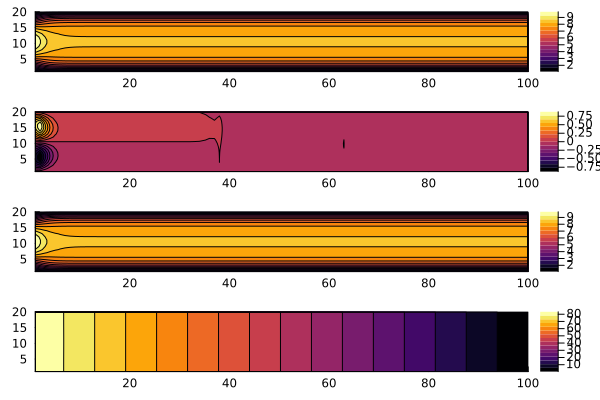

In [66]:
dim = 2 
degree = 2

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # required for pressure constraint 

# Boundary conditions 
ch = ConstraintHandler(dh)

# Ramp the inlet velocity 
vmax = 10. 
vin(t) = min(t * vmax, vmax) #inflow velocity
# vin(t) = vmax 
parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(R - x[2])/R^2, 0.0))
# parabolic_inflow_profile(x,t) = Vec((vmax*4*x[2]*(R - x[2])/R^2, 0.0))

# Case-(1/3): Inlet Prescribed Velocity - Textbook case
if (true) # (true)
    # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    add!(ch, dbc1)

    # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        # getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 0)
    add!(ch, dbc3)
end 

# Case-(2/3): Inlet Prescribed Pressure and Zero Velocity Inlet - Outlet Open 
if (false)
    # Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:p, inlet, (x,t) ->  1.)
    add!(ch, dbc1)
    
    dbc4 = Dirichlet(:u, inlet, (x,t) ->  [100.,0.], [1,2])
    # add!(ch, dbc4)

    # Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    # mean_value_constraint = setup_mean_constraint(dh, fvp)
    # add!(ch, mean_value_constraint) 
    outlet = getfacetset(dh.grid, "right")
    dbc3 = Dirichlet(:p, outlet, (x,t) ->  0)
    add!(ch, dbc3)
end 

# Case-(3/3): Inlet Prescribed Pressure and Zero Velocity Inlet - Outlet Closed 
if (false) # (false)
    # Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    # dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    dbc1 = Dirichlet(:p, inlet, (x,t) ->  1.)
    add!(ch, dbc1)
    
    dbc4 = Dirichlet(:u, inlet, (x,t) ->  [1.,0.], [1,2])
    add!(ch, dbc4)

    # Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    # mean_value_constraint = setup_mean_constraint(dh, fvp)
    # add!(ch, mean_value_constraint) 
    outlet = getfacetset(dh.grid, "right")
    dbc3 = Dirichlet(:p, outlet, (x,t) ->  0)
    add!(ch, dbc3)
end 

# Finalize
close!(ch)

# Global tangent matrix and rhs
# coupling = [true true; true false] # no coupling between pressure test/trial functions
coupling = [true true; true true] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
M = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Assemble system
viscosity = 1e-3 #  1e-5 # 1e3
damping = 10.
if (false)
    K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity, damping);  
elseif (true) # alternative Stokes solve 
    K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity, 0.)
    M = assemble_mass_matrix!(cvu, cvp, M, dh)
    K[gdof_range_u, gdof_range_u] .+= damping*M[gdof_range_u, gdof_range_u]
else 
    K = assemble_oseen_matrix!(K, dh, cvu, cvp, viscosity, damping); 
end 

# Apply boundary conditions and solve
update!(ch, 2.)
apply!(K, f, ch)
u = K \ f;

VTKGridFile("stokes_stationary_closed_channel_mu1e3", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

# Post-processing 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(u, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

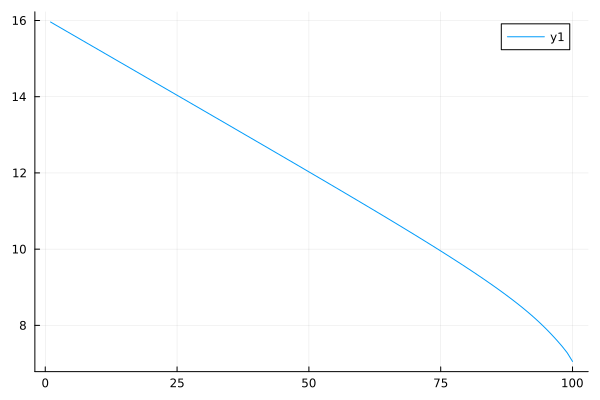

In [53]:
plot(pres2d[:,10])

In [54]:
pressure_drop = (8*1*viscosity*L)  / (R^2)

0.7999999999999998

In [55]:
dim = 2 
degree = 2

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # required for pressure constraint 

# Boundary conditions 
ch = ConstraintHandler(dh)

# Ramp the inlet velocity 
vmax = 10. 
vin(t) = min(t * vmax, vmax) #inflow velocity
# vin(t) = vmax 
parabolic_inflow_profile(x,t) = Vec((vin(t)*4*x[2]*(R - x[2])/R^2, 0.0))
# parabolic_inflow_profile(x,t) = Vec((vmax*4*x[2]*(R - x[2])/R^2, 0.0))

# Case-(1/3): Inlet Prescribed Velocity - Textbook case
if (true) # (true)
    # Inlet: Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    add!(ch, dbc1)

    # Walls: Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        # getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    dbc3 = Dirichlet(:p, getfacetset(grid, "right"), (x, t) -> 0)
    add!(ch, dbc3)
end 

# Case-(2/3): Inlet Prescribed Pressure and Zero Velocity Inlet - Outlet Open 
if (false)
    # Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    dbc1 = Dirichlet(:p, inlet, (x,t) ->  1.)
    add!(ch, dbc1)
    
    dbc4 = Dirichlet(:u, inlet, (x,t) ->  [100.,0.], [1,2])
    # add!(ch, dbc4)

    # Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    # mean_value_constraint = setup_mean_constraint(dh, fvp)
    # add!(ch, mean_value_constraint) 
    outlet = getfacetset(dh.grid, "right")
    dbc3 = Dirichlet(:p, outlet, (x,t) ->  0)
    add!(ch, dbc3)
end 

# Case-(3/3): Inlet Prescribed Pressure and Zero Velocity Inlet - Outlet Closed 
if (false) # (false)
    # Boundary conditions part (1/3): Dirichlet BC for the velocity at the left patch 
    inlet = getfacetset(dh.grid, "left")
    # dbc1 = Dirichlet(:u, inlet, (x,t) ->  parabolic_inflow_profile(x,t) )
    dbc1 = Dirichlet(:p, inlet, (x,t) ->  1.)
    add!(ch, dbc1)
    
    dbc4 = Dirichlet(:u, inlet, (x,t) ->  [1.,0.], [1,2])
    add!(ch, dbc4)

    # Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
    wall = union(
        getfacetset(grid, "top"),
        getfacetset(grid, "right"),
        getfacetset(grid, "bottom"), 
    )
    dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
    add!(ch, dbc2)
    
    # Boundary conditions part (3/3): apply pressure constraint
    # mean_value_constraint = setup_mean_constraint(dh, fvp)
    # add!(ch, mean_value_constraint) 
    outlet = getfacetset(dh.grid, "right")
    dbc3 = Dirichlet(:p, outlet, (x,t) ->  0)
    add!(ch, dbc3)
end 

# Finalize
close!(ch)

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch; coupling=coupling);
M = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
f = zeros(ndofs(dh));

# Global stiffness matrix, mass matrix and rhs
# coupling = [true true; true false] # no coupling between pressure test/trial functions
coupling = [true true; true true] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Assemble system
viscosity = 1e-5 #  1e-5 # 1e3
assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity); 

# Apply boundary conditions and solve
update!(ch, 2.)
K = K - .01*M
apply!(K, f, ch)
u = K \ f;

VTKGridFile("stokes_stationary_closed_channel_mu1e3", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

# Post-processing 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(u, dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

LoadError: MethodError: no method matching assemble_stokes_matrix!(::SparseMatrixCSC{Float64, Int64}, ::DofHandler{2, Grid{2, Quadrilateral, Float64}}, ::CellValues{Ferrite.FunctionValues{1, VectorizedInterpolation{2, RefQuadrilateral, 3, Lagrange{RefQuadrilateral, 3}}, Matrix{Vec{2, Float64}}, Matrix{Tensor{2, 2, Float64, 4}}, Matrix{Tensor{2, 2, Float64, 4}}, Nothing, Nothing}, Ferrite.GeometryMapping{1, Lagrange{RefQuadrilateral, 1}, Matrix{Float64}, Matrix{Vec{2, Float64}}, Nothing}, QuadratureRule{RefQuadrilateral, Vector{Float64}, Vector{Vec{2, Float64}}}, Vector{Float64}}, ::CellValues{Ferrite.FunctionValues{1, Lagrange{RefQuadrilateral, 2}, Matrix{Float64}, Matrix{Vec{2, Float64}}, Matrix{Vec{2, Float64}}, Nothing, Nothing}, Ferrite.GeometryMapping{1, Lagrange{RefQuadrilateral, 1}, Matrix{Float64}, Matrix{Vec{2, Float64}}, Nothing}, QuadratureRule{RefQuadrilateral, Vector{Float64}, Vector{Vec{2, Float64}}}, Vector{Float64}}, ::Float64)

[0mClosest candidates are:
[0m  assemble_stokes_matrix!(::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[50]:34[24m[39m


In [18]:
M

44963×44963 SparseMatrixCSC{Float64, Int64} with 2909449 stored entries:
⎡⠻⣦⡈⢧⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠦⣌⠻⣦⡹⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⠓⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⡻⣮⡳⣄⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢮⠻⣦⎦

## Section 1.5: Solve Using Preconditioned Krylov Method 

In [ ]:
prec  = ilu(K, τ = 0.001)
u = ones(size(f))
u, convhist = gmres!(u, K, f; Pl=prec, maxiter=100000, log=true)
plot(convhist[:resnorm], yaxis=:log,lw=2,legend=false) 

## Section 6: Transient Solve by Hand-Coded Implicit Euler Fixed Time-Step Loop 
We verify that a hand-code implicit Euler fixed time-step loop does yield the steady-state solution.  

In [30]:
# allocate and assemble mass matrix 
M = allocate_matrix(dh,ch);
M = assemble_mass_matrix!(cvu, cvp, M, dh);

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity);
f = zeros(ndofs(dh));

In [11]:
# set time constants 
T  = 2.0
dt = 1e-1
nsteps = length(dt:dt:T)

A = copy(M)
A.nzval .= M.nzval .+ dt .* K.nzval

rhsdata = get_rhs_data(ch, A);

# set initial guess 
un = zeros(length(f));
# un = ustationary
unhist = Vector{typeof(un)}(undef,nsteps+1)
unhist[1] = copy(un) 

# apply boundary conditions 
apply!(A, ch);

pvd = paraview_collection("stokes_transient")
VTKGridFile("stokes_transient_0", dh) do vtk
    write_solution(vtk, dh, un)
    pvd[0.0] = vtk
end

for (step, t) in enumerate(dt:dt:T)
    display(step)
    
    #..(1/6) update the Dirichlet boundary condition values.
    update!(ch, t)

    #..(2/6) compute the right-hand-side of the problem.
    b = dt .* f .+ M * un
    
    #..(3/6) apply the boundary conditions of the current time step.
    apply_rhs!(rhsdata, b, ch)

    #..(4/6) solve the time step 
    u = A \ b

    #..(5/6) save the solution
    VTKGridFile("stokes_transient_$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
    
    #..(6/6) set the previous solution to the current one and go to the next time step.
    un .= u
    unhist[step+1] = copy(un) 
    
end

vtk_save(pvd);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

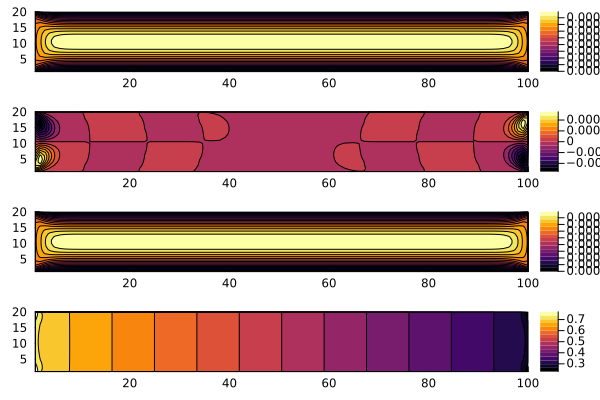

In [12]:
# post-process solution 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(unhist[end], dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

In [30]:
#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    M::SparseMatrixCSC
    ch::ConstraintHandler
    u::Vector
end 

#..right-hand side function for time integration
#..note that modifications to u have local scope only 
function stokes!(du, u_uc, p::RHSparams, t)

    display(t)
    
    @unpack K, M, ch, u = p
    
    u .= u_uc
    update!(ch, t)
    apply!(u, ch)
    
    # Linear contribution (Stokes operator)
    du .= M \ (K * u) 

    return
end

# set time constants 
T   = 1e-2 # 2.0
Δt₀ = 1e-3 # 1e-1

# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
apply!(M, ch)

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e-3
K = -assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
apply!(K, ch)

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, M, ch, copy(uinit))

rhs = ODEFunction(stokes!)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
# sol = solve(problem, Tsit5(), reltol = 1e1, abstol = 1e1);

LoadError: invalid redefinition of constant Main.RHSparams

## Section 7: Implicit Time Integration of the Stokes System Using DifferentialEquations.jl (start again from NS tutorial)

<b>Remarks Regarding the Source Vector</b>
1. the source vector is absent in the right-hand side function;
   
<b>Remarks Regarding the Application of the Boundary Conditions</b>
 

<b>Remarks Regarding the Jacobian</b>
1. omitting the Jacobian lead to problem that Jacobian cannot be generated using automatic differention. Analytical Jacobian needs to be supplied;
2. omitting the argumennt jac_prototype is such that the Jacobian J fails to be recognized as sparse and the call nonzeros(J) fails due to a method error;
3. in the construction of the Jacobian, the function apply!(J,ch) is called to elimiated the constrained dofs from the Jacobian. This is done to decouple the constrained dofs in the nonlinear solver from the remaining system; 

In [31]:
#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    u::Vector
end 

In [32]:
#..right-hand side function for time integration
#..note that modifications to u have local scope only 
function stokes!(du, u_uc, p::RHSparams, t)

    # display(t)
    
    @unpack K, ch, u = p
    
    u .= u_uc
    update!(ch, t)
    apply!(u, ch)
    
    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end

#..jacobian function for time integration 
function stokes_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, u = p
    
    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)  
    
    return J # apply!(J, ch)    
end

#..applies the boundary conditions.. 
function ferrite_limiter!(u, _, p, t)
    update!(p.ch, t)
    return apply!(u, p.ch)
end

# set time constants 
T   = 2.0
Δt₀ = 1e-1

# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
apply!(M, ch)

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e-3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
#apply!(K, ch)

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))

# set parameters 
p = RHSparams(K, ch, copy(uinit))

rhs = ODEFunction(stokes!, mass_matrix = M; jac = stokes_jac!, jac_prototype = jac_sparsity)
problem = ODEProblem(rhs, uinit, (0.0, T), p);
# sol = solve(problem, Rodas5(autodiff=false, step_limiter! = ferrite_limiter!), reltol = 1e1, abstol = 1e1);
sol = solve(problem, ImplicitEuler(autodiff=false); dt = Δt₀, 
        adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
        verbose = true)

┌ Warning: At t=1.778206999588062e-162, dt was forced below floating point epsilon 2.4677579418653533e-178, and step error estimate = NaN. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase ~/.julia/packages/SciMLBase/sN1tQ/src/integrator_interface.jl:623


retcode: Unstable
Interpolation: 3rd order Hermite
t: 2-element Vector{Float64}:
 0.0
 1.778206999588062e-162
u: 2-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [21]:
length(sol.u)

1

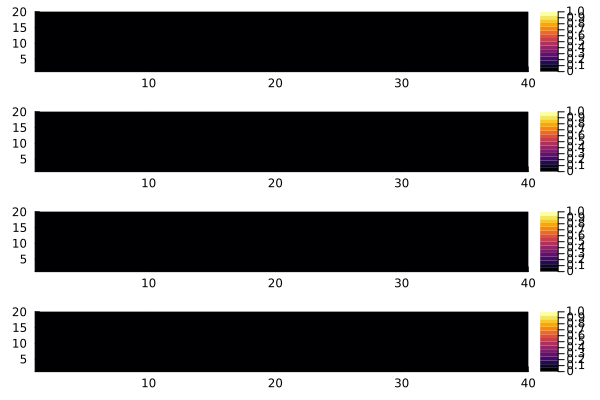

In [22]:
# post-process solution 
area, velx2d, vely2d, velm2d, pres2d = mypostprocess(sol.u[end], dh) 
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(velm2d', fill=true)
p4 = contour(pres2d', fill=true)
plot(p1,p2,p3,p4,layout=(4,1))

In [17]:
#..pass data to RHS of time integration 
struct RHSparams
    K::SparseMatrixCSC
    ch::ConstraintHandler
    u::Vector
end

struct FreeDofErrorNorm
    ch::ConstraintHandler
end

LoadError: invalid redefinition of constant Main.RHSparams

In [18]:
function old_stokes!(du, u_uc, p::RHSparams, t)

    display(t)

    @unpack K, ch, u = p

    u .= u_uc
    update!(ch, t)
    apply!(u, ch)

    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

# one is **not** allowed to mutate the input argument u_uc to apply the boundary conditions 
function stokes!(du, u_uc, p::RHSparams, t)

    display(t)
    
    @unpack K, ch, u = p
    
    u .= u_uc
    update!(ch, t)
    apply!(u, ch) # is this necessary or is the limiter instead sufficient for all purposes  
    
    # Linear contribution (Stokes operator)
    mul!(du, K, u) # du .= K * u

    return
end;

In [19]:
function old_stokes_jac!(J, u_uc, p, t)

    @unpack K, ch, u = p

    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    return apply!(J, ch)
end

function stokes_jac!(J, u_uc, p::RHSparams, t)

    @unpack K, ch, u = p
    
    # update constraint handler 
    update!(ch, t)

    # Linear contribution (Stokes operator)
    # Here we assume that J has exactly the same structure as K by construction
    nonzeros(J) .= nonzeros(K)

    return apply!(J, ch)    
end

stokes_jac! (generic function with 1 method)

In [29]:
# set time constants 
T   = 2.0
Δt₀ = 1e-1

# allocate, assemble and apply bc to mass matrix 
M = allocate_matrix(dh);
M = assemble_mass_matrix!(cvu, cvp, M, dh);
apply!(M, ch)

# allocate and assemble the stiffness matrix 
K = allocate_matrix(dh,ch);
viscosity = 1e3
K = assemble_stokes_matrix!(K, dh, cvu, cvp, viscosity)
apply!(K, ch)
K = -K 

# set sparsity pattern 
jac_sparsity = sparse(K);

# set initial guess 
uinit = zeros(ndofs(dh))
#uinit = ustationary 

# set parameters 
p = RHSparams(K, ch, copy(uinit))

rhs = ODEFunction(stokes!, mass_matrix = M; jac = stokes_jac!, jac_prototype = jac_sparsity)
# rhs = ODEFunction(stokes!, mass_matrix = M) 
problem = ODEProblem(rhs, uinit, (0.0, T), p);

(fe_norm::FreeDofErrorNorm)(u::Union{AbstractFloat, Complex}, t) = DiffEqBase.ODE_DEFAULT_NORM(u, t)
(fe_norm::FreeDofErrorNorm)(u::AbstractArray, t) = DiffEqBase.ODE_DEFAULT_NORM(u[fe_norm.ch.free_dofs], t)

# sol = solve(problem, ImplicitEuler(),verbose = true)
# sol = solve(problem, ImplicitEuler(autodiff=false); dt = Δt₀, verbose = true)
sol = solve(problem, ImplicitEuler(autodiff=false); dt = Δt₀, 
        adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
        verbose = true)

LoadError: MethodError: no method matching RHSparams(::SparseMatrixCSC{Float64, Int64}, ::ConstraintHandler{DofHandler{2, Grid{2, Quadrilateral, Float64}}, Float64}, ::Vector{Float64})

[0mClosest candidates are:
[0m  RHSparams(::Any, ::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[14]:3[24m[39m
[0m  RHSparams(::SparseMatrixCSC, [91m::SparseMatrixCSC[39m, [91m::ConstraintHandler[39m, [91m::Vector[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[14]:3[24m[39m


In [21]:
# timestepper = ImplicitEuler(autodiff=false)
timestepper = ImplicitEuler()
# timestepper = Euler()

integrator = init(
    problem, timestepper; dt = Δt₀,
    adaptive = true, abstol = 1.0e-4, reltol = 1.0e-5,
    progress = true, progress_steps = 1,
    verbose = true, internalnorm = FreeDofErrorNorm(ch), d_discontinuities = [1.0]
);

pvd = paraview_collection("stokes-channel-2d")
for (step, (u, t)) in enumerate(intervals(integrator))
    display(t)
    VTKGridFile("stokes-channel-2d$step", dh) do vtk
        write_solution(vtk, dh, u)
        pvd[t] = vtk
    end
end
vtk_save(pvd);

LoadError: UndefVarError: `FreeDofErrorNorm` not defined